In [13]:
# 导入数据
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)              #取消行限制
pd.set_option('display.max_columns',None)           #取消列限制，让所有数据显示出来，没有省略号

train_data = pd.read_csv('train_data.csv',header=0)  #读取数据
train_data = pd.DataFrame(train_data)  #把数据转化成float(浮点型)，否则为int型
test_data = pd.read_csv('test_data.csv',header=0)  #读取数据
test_data = pd.DataFrame(test_data)  #把数据转化成float(浮点型)，否则为int型
from pandas import set_option
from matplotlib import pyplot

X_train = train_data.drop("1-year readmission",axis=1)
Y_train = train_data["1-year readmission"]

X_test = test_data.drop("1-year readmission",axis=1)
Y_test = test_data["1-year readmission"]

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler                
import catboost as cb

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
scoring = 'roc_auc'  # 评价指标scoring可以等于'roc_auc'，'accuracy'，'recall'等
num_folds = 10
seed = 7

from sklearn.metrics import roc_auc_score,roc_curve,auc
CatBoost = cb.CatBoostClassifier( n_estimators=246,silent=True)
CatBoost.fit(X=X_train, y=Y_train)
CatBoost_predict = CatBoost.predict_proba(X_test)[:,1]
CatBoost_predict_roc = roc_auc_score(y_true=Y_test, y_score=CatBoost_predict)
print("CatBoost测试集AUC",CatBoost_predict_roc)

CatBoost_predict = CatBoost.predict_proba(X_test)[:,1]

import joblib
# 将模型保存为文件
#joblib.dump(CatBoost, 'CatBoost.pkl')

CatBoost测试集AUC 0.7088607594936709


In [88]:
d = []
for i in X_train.columns.tolist():
    #print(train_data[i].dtype)
    if len(pd.unique(train_data[i]).tolist())<10:
        d.append({"type":"choice", "name":i, "data":pd.unique(train_data[i]).tolist()})
    else:
        x = []
        for j in pd.unique(train_data[i]).tolist():
            if j-int(j)>0:
                x.append(False)
            else:
                x.append(True)
        if all(x):
            d.append({"type":"number", "name":i, "dtype":"int", "step":1})
            print(i)
        else:
            d.append({"type":"number", "name":i, "dtype":"float", "step":0.01})

LOS
DBP
LA
RA
NOM


In [89]:
d

[{'type': 'choice', 'name': 'Sex', 'data': [0.0, 1.0]},
 {'type': 'choice',
  'name': 'Educational level',
  'data': [2.0, 3.0, 1.0, 0.0, 4.0]},
 {'type': 'choice', 'name': 'Smoking status', 'data': [0.0, 1.0]},
 {'type': 'choice', 'name': 'PCI', 'data': [0.0, 1.0]},
 {'type': 'choice',
  'name': 'Number of affected vessels',
  'data': [1.0, 0.0, 3.0, 2.0, 4.0]},
 {'type': 'choice', 'name': 'HF', 'data': [1.0, 0.0]},
 {'type': 'choice', 'name': 'COPD', 'data': [0.0, 1.0]},
 {'type': 'choice', 'name': 'Hepatic disease', 'data': [0.0, 2.0, 1.0, 3.0]},
 {'type': 'choice', 'name': 'Antiplatelet', 'data': [1.0, 2.0, 0.0]},
 {'type': 'choice', 'name': 'Lipid-lowering drug', 'data': [1.0, 0.0, 2.0]},
 {'type': 'choice', 'name': 'PPI', 'data': [0.0, 1.0]},
 {'type': 'number', 'name': 'LOS', 'dtype': 'int', 'step': 1},
 {'type': 'number', 'name': 'DBP', 'dtype': 'int', 'step': 1},
 {'type': 'number', 'name': 'LA', 'dtype': 'int', 'step': 1},
 {'type': 'number', 'name': 'RA', 'dtype': 'int', 'st

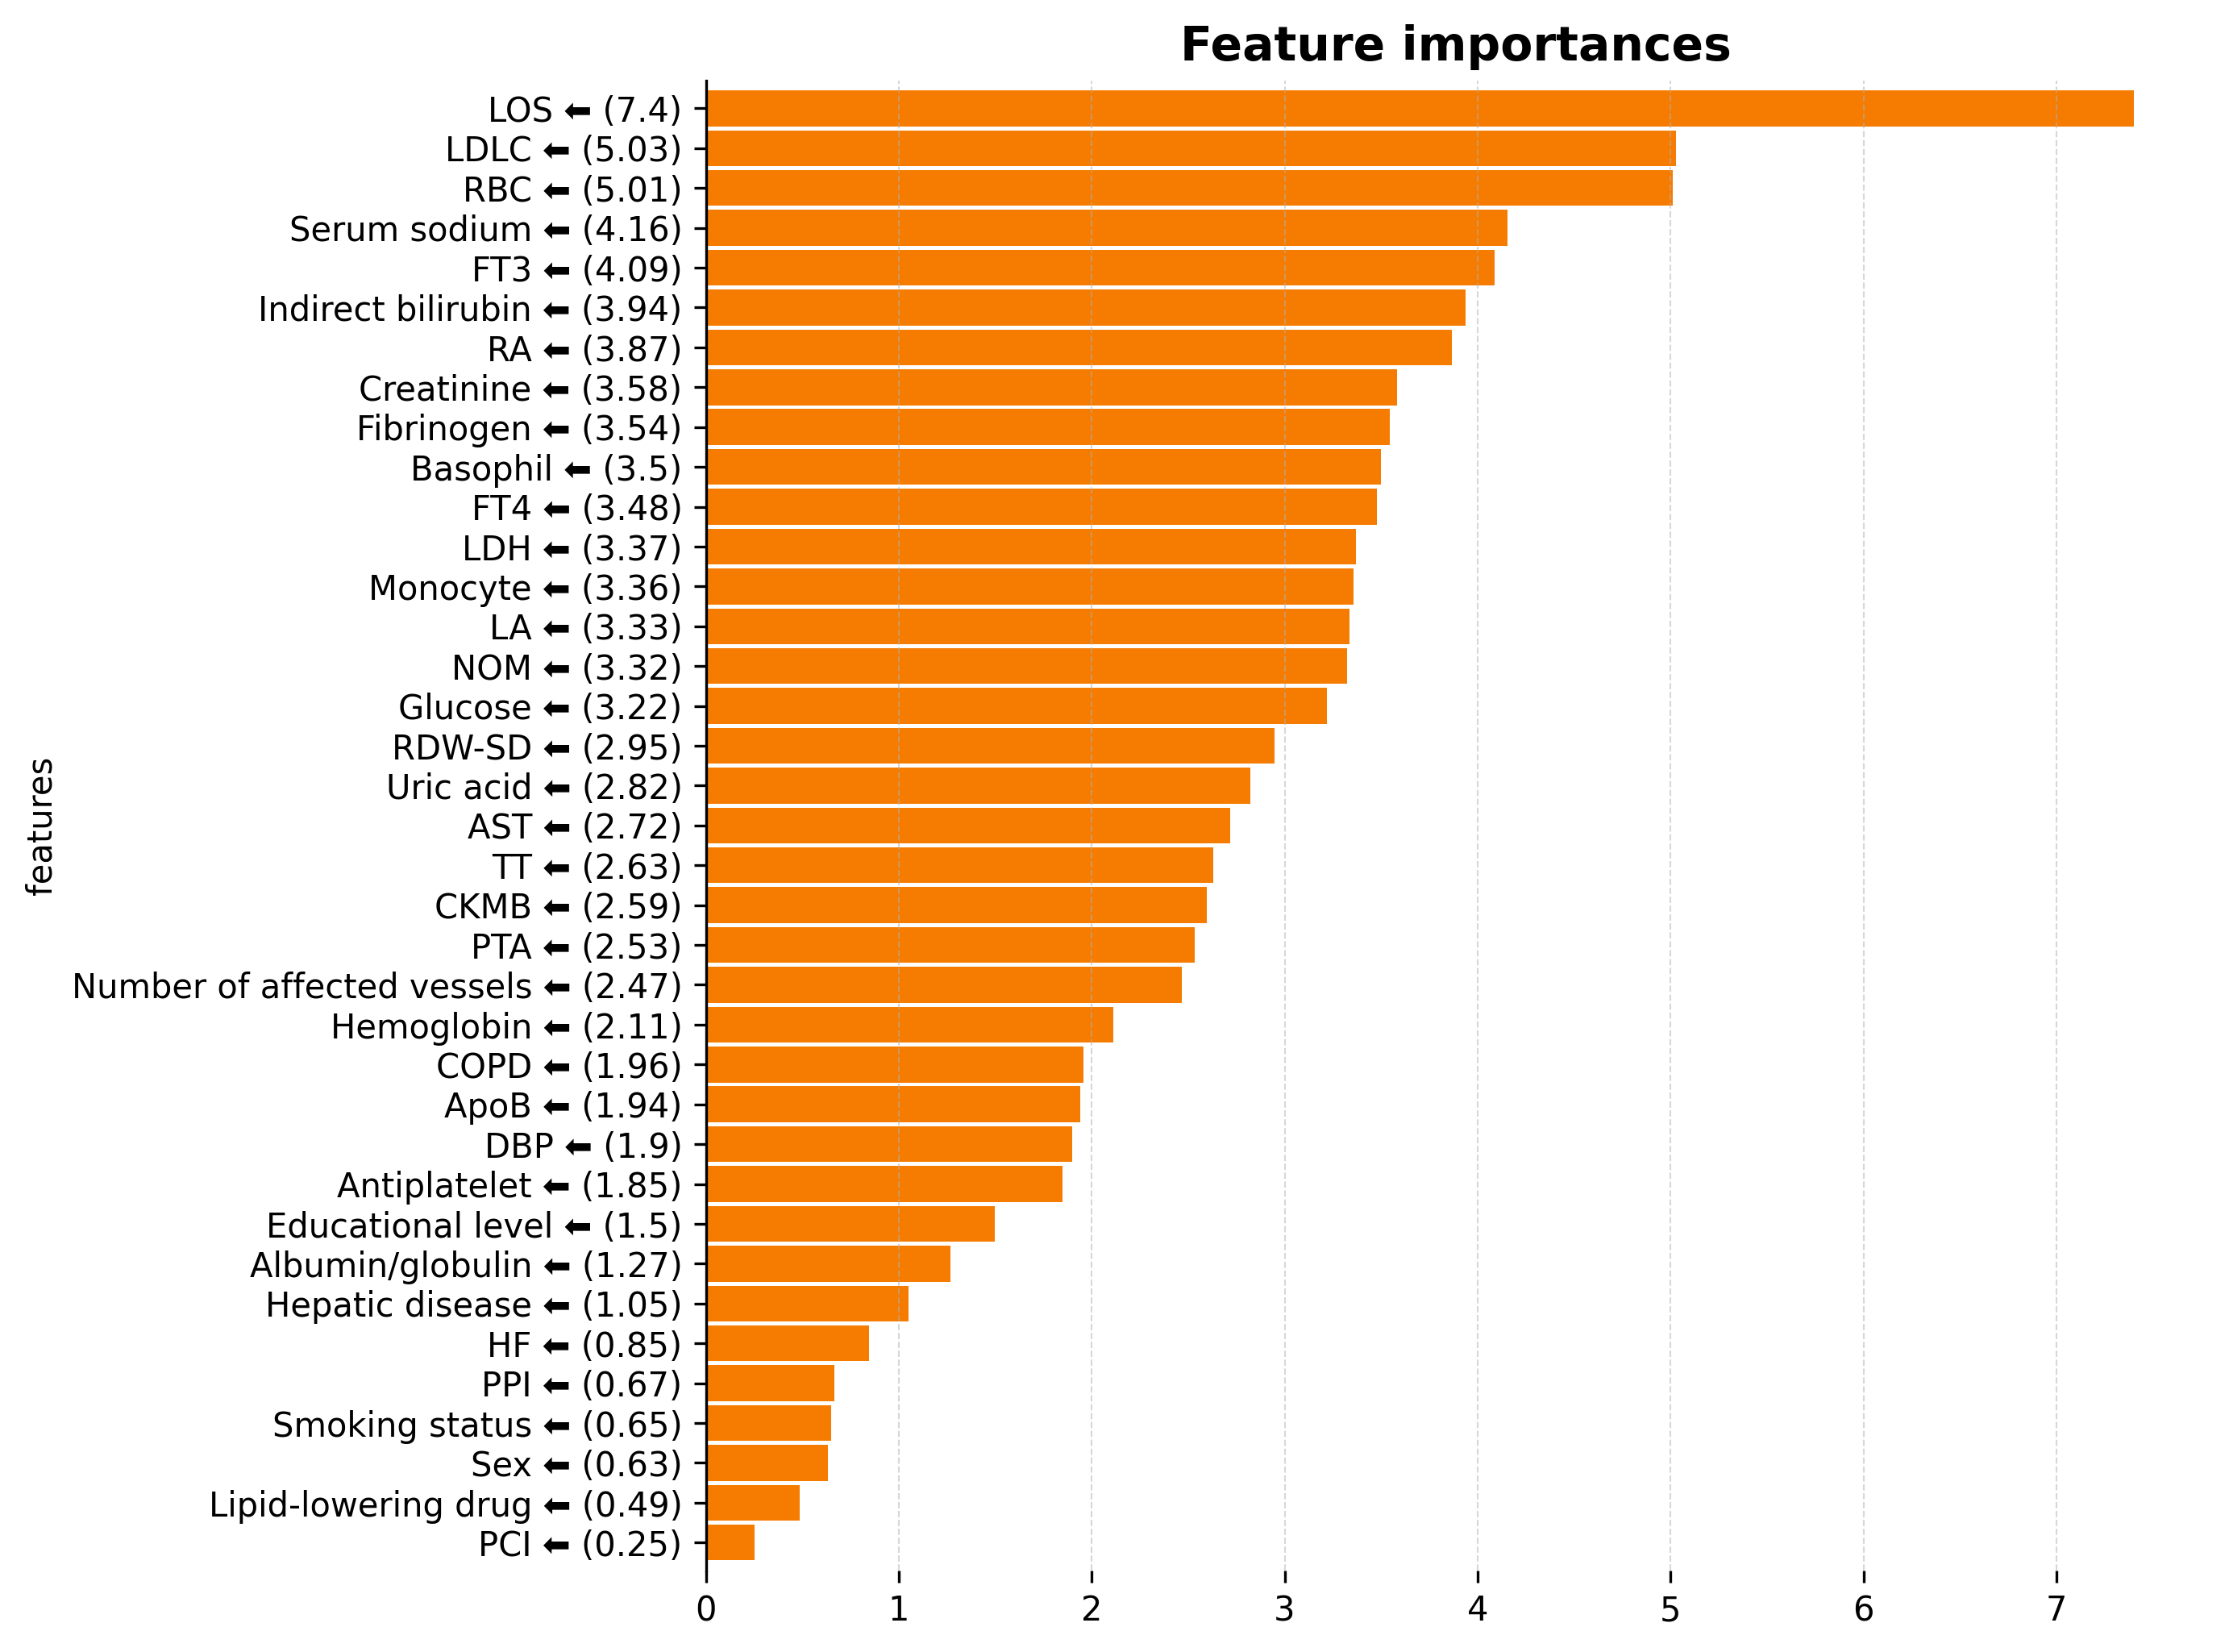

In [54]:
m = joblib.load('CatBoost.pkl')

import matplotlib.pyplot as plt

# 获取特征重要性  
feature_importances = m.get_feature_importance()  
features = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])  
df = pd.DataFrame({"feature importances":feature_importances, "features":features})
df = df.sort_values(by="feature importances")
df["features"] = df.apply(lambda x: x["features"]+f' ⬅ ({round(x["feature importances"], 2)})', axis=1)

plt.figure(figsize=(8, 8), dpi=300)
df.plot(kind="barh", y="feature importances", x="features", ax=plt.gca(), width=0.9, legend=False, color="#F57C00")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.bottom.set_visible(False)
plt.grid(axis="x", ls="--", lw=0.5, alpha=0.5)
plt.title("Feature importances", fontsize=14, fontweight="bold")

plt.show()

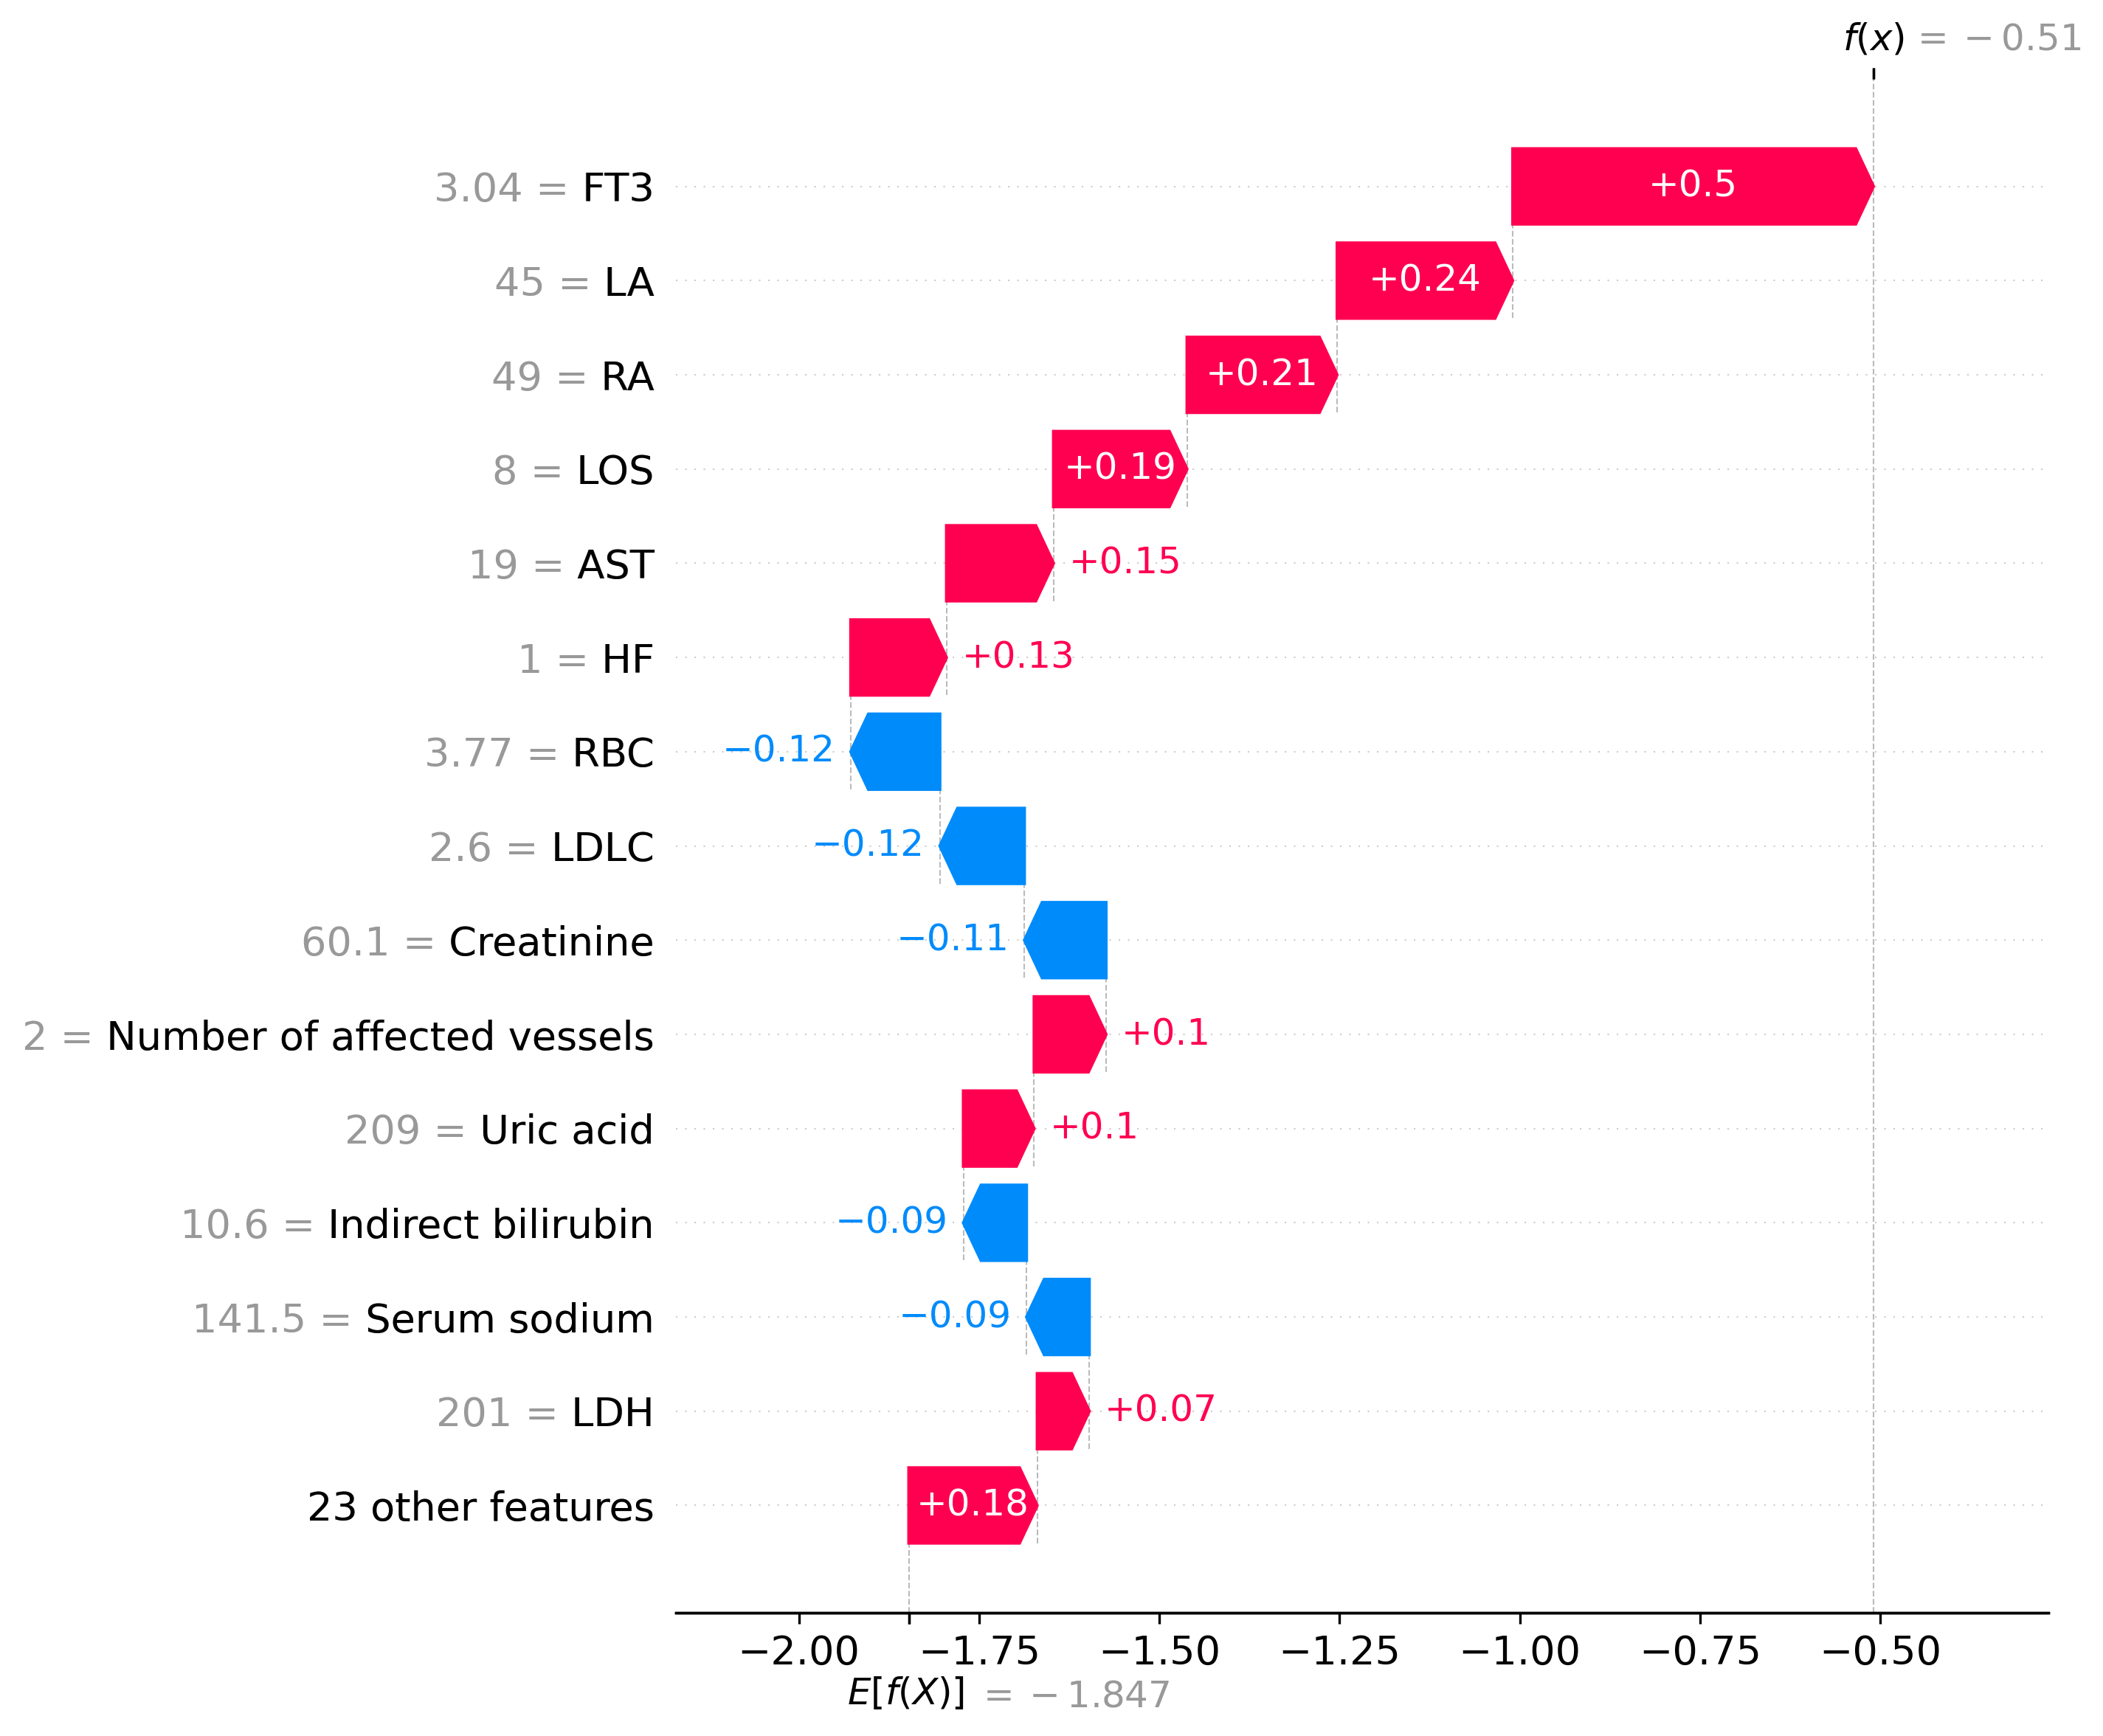

In [84]:
import shap  

# 创建SHAP解释器  
explainer = shap.Explainer(m)  
shap_values = explainer(X_test.iloc[:1])  

# 绘制瀑布图  
plt.figure(figsize=(8, 4), dpi=300)  
shap.waterfall_plot(shap_values[0], max_display=15)  
plt.show()